In [2]:
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.array as cl_array
from tqdm import tqdm
import time
from contextlib import contextmanager
from functools import reduce
import math
from pprint import pprint
import matplotlib.pyplot as plt
import sys
import threading

In [3]:
platforms = cl.get_platforms()

def get_platform_info(platform):
    keys = [
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "HOST_TIMER_RESOLUTION",
        "NAME",
        "NUMERIC_VERSION",
        "PROFILE",
        "VENDOR",
        "VERSION",
    ]
    info = {}
    for key in keys:
        try:
            value = platform.get_info(getattr(cl.platform_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

platform_infos = list(map(get_platform_info, platforms))
if len(platforms) > 1:
    print(f"> Listing platforms ({len(platforms)})")
    pprint(platform_infos)

platform_index = 0
platform = platforms[platform_index]
platform_info = platform_infos[platform_index]

print(f"> Selected platform ({platform_index})")
pprint(platform_info)

def get_device_info(device):
    keys = [
        "ADDRESS_BITS",
        "ATOMIC_FENCE_CAPABILITIES",
        "ATOMIC_MEMORY_CAPABILITIES",
        "ATTRIBUTE_ASYNC_ENGINE_COUNT_NV",
        "AVAILABLE",
        "AVAILABLE_ASYNC_QUEUES_AMD",
        "BOARD_NAME_AMD",
        "BUILT_IN_KERNELS",
        "BUILT_IN_KERNELS_WITH_VERSION",
        "COMPILER_AVAILABLE",
        "COMPUTE_CAPABILITY_MAJOR_NV",
        "COMPUTE_CAPABILITY_MINOR_NV",
        "DEVICE_ENQUEUE_CAPABILITIES",
        "DOUBLE_FP_CONFIG",
        "DRIVER_VERSION",
        "ENDIAN_LITTLE",
        "ERROR_CORRECTION_SUPPORT",
        "EXECUTION_CAPABILITIES",
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "EXT_MEM_PADDING_IN_BYTES_QCOM",
        "GENERIC_ADDRESS_SPACE_SUPPORT",
        "GFXIP_MAJOR_AMD",
        "GFXIP_MINOR_AMD",
        "GLOBAL_FREE_MEMORY_AMD",
        "GLOBAL_MEM_CACHELINE_SIZE",
        "GLOBAL_MEM_CACHE_SIZE",
        "GLOBAL_MEM_CACHE_TYPE",
        "GLOBAL_MEM_CHANNELS_AMD",
        "GLOBAL_MEM_CHANNEL_BANKS_AMD",
        "GLOBAL_MEM_CHANNEL_BANK_WIDTH_AMD",
        "GLOBAL_MEM_SIZE",
        "GLOBAL_VARIABLE_PREFERRED_TOTAL_SIZE",
        "GPU_OVERLAP_NV",
        "HALF_FP_CONFIG",
        "HOST_UNIFIED_MEMORY",
        "ILS_WITH_VERSION",
        "IL_VERSION",
        "IMAGE2D_MAX_HEIGHT",
        "IMAGE2D_MAX_WIDTH",
        "IMAGE3D_MAX_DEPTH",
        "IMAGE3D_MAX_HEIGHT",
        "IMAGE3D_MAX_WIDTH",
        "IMAGE_BASE_ADDRESS_ALIGNMENT",
        "IMAGE_MAX_ARRAY_SIZE",
        "IMAGE_MAX_BUFFER_SIZE",
        "IMAGE_PITCH_ALIGNMENT",
        "IMAGE_SUPPORT",
        "INTEGRATED_MEMORY_NV",
        "KERNEL_EXEC_TIMEOUT_NV",
        "LINKER_AVAILABLE",
        "LOCAL_MEM_BANKS_AMD",
        "LOCAL_MEM_SIZE",
        "LOCAL_MEM_SIZE_PER_COMPUTE_UNIT_AMD",
        "LOCAL_MEM_TYPE",
        "MAX_ATOMIC_COUNTERS_EXT",
        "MAX_CLOCK_FREQUENCY",
        "MAX_COMPUTE_UNITS",
        "MAX_CONSTANT_ARGS",
        "MAX_CONSTANT_BUFFER_SIZE",
        "MAX_GLOBAL_VARIABLE_SIZE",
        "MAX_MEM_ALLOC_SIZE",
        "MAX_NUM_SUB_GROUPS",
        "MAX_ON_DEVICE_EVENTS",
        "MAX_ON_DEVICE_QUEUES",
        "MAX_PARAMETER_SIZE",
        "MAX_PIPE_ARGS",
        "MAX_READ_IMAGE_ARGS",
        "MAX_READ_WRITE_IMAGE_ARGS",
        "MAX_SAMPLERS",
        "MAX_WORK_GROUP_SIZE",
        "MAX_WORK_GROUP_SIZE_AMD",
        "MAX_WORK_ITEM_DIMENSIONS",
        "MAX_WORK_ITEM_SIZES",
        "MAX_WRITE_IMAGE_ARGS",
        "MEM_BASE_ADDR_ALIGN",
        "ME_VERSION_INTEL",
        "MIN_DATA_TYPE_ALIGN_SIZE",
        "NAME",
        "NATIVE_VECTOR_WIDTH_CHAR",
        "NATIVE_VECTOR_WIDTH_DOUBLE",
        "NATIVE_VECTOR_WIDTH_FLOAT",
        "NATIVE_VECTOR_WIDTH_HALF",
        "NATIVE_VECTOR_WIDTH_INT",
        "NATIVE_VECTOR_WIDTH_LONG",
        "NATIVE_VECTOR_WIDTH_SHORT",
        "NON_UNIFORM_WORK_GROUP_SUPPORT",
        "NUMERIC_VERSION",
        "NUM_SIMULTANEOUS_INTEROPS_INTEL",
        "OPENCL_C_ALL_VERSIONS",
        "OPENCL_C_FEATURES",
        "OPENCL_C_VERSION",
        "PAGE_SIZE_QCOM",
        "PARENT_DEVICE",
        "PARTITION_AFFINITY_DOMAIN",
        "PARTITION_MAX_SUB_DEVICES",
        "PARTITION_PROPERTIES",
        "PARTITION_TYPE",
        "PCIE_ID_AMD",
        "PCI_BUS_ID_NV",
        "PCI_DOMAIN_ID_NV",
        "PCI_SLOT_ID_NV",
        "PIPE_MAX_ACTIVE_RESERVATIONS",
        "PIPE_MAX_PACKET_SIZE",
        "PIPE_SUPPORT",
        "PLATFORM",
        "PREFERRED_CONSTANT_BUFFER_SIZE_AMD",
        "PREFERRED_GLOBAL_ATOMIC_ALIGNMENT",
        "PREFERRED_INTEROP_USER_SYNC",
        "PREFERRED_LOCAL_ATOMIC_ALIGNMENT",
        "PREFERRED_PLATFORM_ATOMIC_ALIGNMENT",
        "PREFERRED_VECTOR_WIDTH_CHAR",
        "PREFERRED_VECTOR_WIDTH_DOUBLE",
        "PREFERRED_VECTOR_WIDTH_FLOAT",
        "PREFERRED_VECTOR_WIDTH_HALF",
        "PREFERRED_VECTOR_WIDTH_INT",
        "PREFERRED_VECTOR_WIDTH_LONG",
        "PREFERRED_VECTOR_WIDTH_SHORT",
        "PREFERRED_WORK_GROUP_SIZE_AMD",
        "PREFERRED_WORK_GROUP_SIZE_MULTIPLE",
        "PRINTF_BUFFER_SIZE",
        "PROFILE",
        "PROFILING_TIMER_OFFSET_AMD",
        "PROFILING_TIMER_RESOLUTION",
        "QUEUE_ON_DEVICE_MAX_SIZE",
        "QUEUE_ON_DEVICE_PREFERRED_SIZE",
        "QUEUE_ON_DEVICE_PROPERTIES",
        "QUEUE_ON_HOST_PROPERTIES",
        "QUEUE_PROPERTIES",
        "REFERENCE_COUNT",
        "REGISTERS_PER_BLOCK_NV",
        "SIMD_INSTRUCTION_WIDTH_AMD",
        "SIMD_PER_COMPUTE_UNIT_AMD",
        "SIMD_WIDTH_AMD",
        "SIMULTANEOUS_INTEROPS_INTEL",
        "SINGLE_FP_CONFIG",
        "SPIR_VERSIONS",
        "SUB_GROUP_INDEPENDENT_FORWARD_PROGRESS",
        "SVM_CAPABILITIES",
        "THREAD_TRACE_SUPPORTED_AMD",
        "TOPOLOGY_AMD",
        "TYPE",
        "VENDOR",
        "VENDOR_ID",
        "VERSION",
        "WARP_SIZE_NV",
        "WAVEFRONT_WIDTH_AMD",
        "WORK_GROUP_COLLECTIVE_FUNCTIONS_SUPPORT",
    ]
    info = {}
    for key in keys:
        try:
            value = device.get_info(getattr(cl.device_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

devices = platform.get_devices()
device_infos = list(map(get_device_info, devices))
if len(devices) > 1:
    print(f"> Listing devices ({len(devices)})")
    pprint(device_infos)

device_index = 0
device = devices[device_index]
device_info = device_infos[device_index]

print(f"> Selected device ({device_index})")
pprint(device_info)

context = cl.Context(devices=[device])

> Selected platform (0)
{'extensions': {'cl_amd_event_callback',
                'cl_amd_offline_devices',
                'cl_khr_d3d10_sharing',
                'cl_khr_d3d11_sharing',
                'cl_khr_dx9_media_sharing',
                'cl_khr_icd'},
 'host_timer_resolution': 100,
 'name': 'AMD Accelerated Parallel Processing',
 'profile': 'FULL_PROFILE',
 'vendor': 'Advanced Micro Devices, Inc.',
 'version': 'OpenCL 2.1 AMD-APP (3628.0)'}
> Selected device (0)
{'address_bits': 64,
 'available': 1,
 'available_async_queues_amd': 2,
 'board_name_amd': 'AMD Radeon(TM) Graphics',
 'built_in_kernels': '',
 'compiler_available': 1,
 'double_fp_config': 63,
 'driver_version': '3628.0 (PAL,LC)',
 'endian_little': 1,
 'error_correction_support': 0,
 'execution_capabilities': 1,
 'extensions': {'cl_amd_copy_buffer_p2p',
                'cl_amd_device_attribute_query',
                'cl_amd_media_ops',
                'cl_amd_media_ops2',
                'cl_amd_planar_yuv',
       

In [4]:
class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None
    
    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end_ns = time.time_ns()        

    def get_delta_ns(self):
        return self.end_ns - self.start_ns

In [5]:
program_source = f"""
    __kernel void update_E(
        __global float *E, __global float *H, 
        __global float *A_0, __global float *A_1,
        int Nx, int Ny, int Nz
    ) {{
        // a = 1/2 * Co/ek * sigma_k * dxyz * Z0
        // a_0 = (1-a)/(1+a)
        // a_1 = Co/ek * 1/(1+a)
    
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);
        const int iz = get_global_id(2);

        if (ix >= Nx) return;
        if (iy >= Ny) return;
        if (iz >= Nz) return;

        const int n_dims = 3;
        const int Nzy = Nz*Ny;
        const int i0 = iz + iy*Nz + ix*Nzy;
        const int i = n_dims*i0;
        const int dz = n_dims*(((iz+1) % Nz) + iy*Nz + ix*Nzy);
        const int dy = n_dims*(iz + ((iy+1) % Ny)*Nz + ix*Nzy);
        const int dx = n_dims*(iz + iy*Nz + ((ix+1) % Nx)*Nzy);

        // curl(H)
        const float dHz_dy = H[dy+2]-H[i+2];
        const float dHy_dz = H[dz+1]-H[i+1];
        const float dHx_dz = H[dz+0]-H[i+0];
        const float dHz_dx = H[dx+2]-H[i+2];
        const float dHy_dx = H[dx+1]-H[i+1]; 
        const float dHx_dy = H[dy+0]-H[i+0];
        const float cHx = dHz_dy-dHy_dz;
        const float cHy = dHx_dz-dHz_dx;
        const float cHz = dHy_dx-dHx_dy;

        const float a_0 = A_0[i0];
        const float a_1 = A_1[i0];

        E[i+0] = E[i+0]*a_0 + a_1*cHx;
        E[i+1] = E[i+1]*a_0 + a_1*cHy;
        E[i+2] = E[i+2]*a_0 + a_1*cHz;
        return;
    }}

    __kernel void update_H(
        __global float *E, __global float *H,
        __global float *A_0,
        int Nx, int Ny, int Nz
    ) {{
        // a_0 = Co/ek
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);
        const int iz = get_global_id(2);

        if (ix >= Nx) return;
        if (iy >= Ny) return;
        if (iz >= Nz) return;

        const int n_dims = 3;
        const int Nzy = Nz*Ny;
        const int i0 = iz + iy*Nz + ix*Nzy;
        const int i = n_dims*i0;
        const int dz = n_dims*(((iz-1+Nz) % Nz) + iy*Nz + ix*Nzy);
        const int dy = n_dims*(iz + ((iy-1+Ny) % Ny)*Nz + ix*Nzy);
        const int dx = n_dims*(iz + iy*Nz + ((ix-1+Nx) % Nx)*Nzy);

        // curl(E)
        const float dEz_dy = E[i+2]-E[dy+2];
        const float dEy_dz = E[i+1]-E[dz+1];
        const float dEx_dz = E[i+0]-E[dz+0];
        const float dEz_dx = E[i+2]-E[dx+2];
        const float dEy_dx = E[i+1]-E[dx+1]; 
        const float dEx_dy = E[i+0]-E[dy+0];
        const float cEx = dEz_dy-dEy_dz;
        const float cEy = dEx_dz-dEz_dx;
        const float cEz = dEy_dx-dEx_dy;

        const float a_0 = A_0[i0];
        H[i+0] = H[i+0] - a_0*cEx;
        H[i+1] = H[i+1] - a_0*cEy;
        H[i+2] = H[i+2] - a_0*cEz;
        return;
    }}
"""

gpu_program = cl.Program(context, program_source).build()

C:\Users\acidi\Coding\Projects\wgpu_compute_experiments\pyopencl\venv\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


In [12]:
max_compute_units = device_info["max_compute_units"]
workgroups_per_compute_unit = 2048
max_workgroup_threads = device_info["max_work_group_size"]
max_mem_alloc_size = device_info["max_mem_alloc_size"]

sizeof_type = 4
max_global_threads = max_compute_units*workgroups_per_compute_unit*max_workgroup_threads
max_global_threads = min(max_global_threads*sizeof_type, max_mem_alloc_size) // sizeof_type
max_global_threads = (max_global_threads//max_workgroup_threads) * max_workgroup_threads
print(max_global_threads, max_workgroup_threads)

rng = np.random.default_rng()
grid_size = (16, 256, 512)
#grid_size = (17, 107, 128)
Nx,Ny,Nz = grid_size
n_dims = 3
data_shape = grid_size + (n_dims,)
# workgroup_size = (1,1,256)
workgroup_size = (1,1,256)
max_workgroup_size = device_info["max_work_group_size"]
workgroup_size_count = reduce(lambda x,y: x*y, workgroup_size, 1)
assert(workgroup_size_count <= max_workgroup_size)

actual_grid_size = grid_size
dispatch_size = [math.ceil(x/y) for x,y in zip(actual_grid_size, workgroup_size)]
# assert(all([x % y == 0 for x,y in zip(grid_size, workgroup_size)]))
global_size = [x*y for x,y in zip(dispatch_size, workgroup_size)]
total_cells = reduce(lambda x,y: x*y, actual_grid_size, n_dims)

print("=== Parameters ===")
print(f"grid_size={grid_size}")
print(f"actual_grid_size={actual_grid_size}")
print(f"workgroup_size={workgroup_size}")
print(f"dispatch_size={dispatch_size}")
print(f"global_size={global_size}")
print(f"total_cells={total_cells}")

c_0 = 299792458
mu_0 = 4*math.pi*10**-7 # vacuum permeability
e_0 = 1/(mu_0 * c_0**2)
Z_0 = mu_0*c_0
Co = 1/3**0.5 * 0.99
d_xyz = 1e-6

e_k = np.full(grid_size, 1.0, dtype=np.float32)
sigma_k = np.full(grid_size, 0, dtype=np.float32)

sigma_0 = 1e8
sigma_k[:,30:90,30:40] = sigma_0
#sigma_k[2:-2,30:90,30:40] = sigma_0
# sigma_k[:,30:90,30:40] = sigma_0
# for i in range(0,Ny,20):
    # sigma_k[:,i:i+8,30:36] = sigma_0
# sigma_k[0,:,:] = sigma_0
# sigma_k[-1,:,:] = sigma_0
# sigma_k[:,0,:] = sigma_0
# sigma_k[:,-1,:] = sigma_0
# sigma_k[:,:,0] = sigma_0
# sigma_k[:,:,-1] = sigma_0
# sigma_k[:,:,40:-40] = sigma_0

alpha = (0.5*Co*d_xyz*Z_0)*(sigma_k/e_k) 
a_0 = (1-alpha)/(1+alpha)
a_1 = Co/((1+alpha)*e_k)
b_0 = Co/e_k

E_cpu = np.zeros(data_shape, dtype=np.float32)
H_cpu = np.zeros(data_shape, dtype=np.float32)

width = 10
A = np.cos(np.linspace(-np.pi/2, np.pi/2, width*2, endpoint=True))

signal_pos = [slice(13,26), slice(0,Ny), slice(Nz//2-width, Nz//2+width)]
E_cpu[*signal_pos,0] = A
#E_cpu[*signal_pos,2] = A
H_cpu[*signal_pos,1] = A
#H_cpu[*signal_pos,0] = -A

3145728 256
=== Parameters ===
grid_size=(16, 256, 512)
actual_grid_size=(16, 256, 512)
workgroup_size=(1, 1, 256)
dispatch_size=[16, 256, 2]
global_size=[16, 256, 512]
total_cells=6291456


In [13]:
if False:
    with cl.CommandQueue(context) as queue:
        a_0_gpu = cl_array.zeros(queue, grid_size, np.float32)
        a_1_gpu = cl_array.zeros(queue, grid_size, np.float32)
        b_0_gpu = cl_array.zeros(queue, grid_size, np.float32)
        E_gpu = cl_array.zeros(queue, data_shape, np.float32)
        H_gpu = cl_array.zeros(queue, data_shape, np.float32)
    with cl.CommandQueue(context) as queue:
        a_0_gpu.set(a_0, queue=queue)
        a_1_gpu.set(a_1, queue=queue)
        b_0_gpu.set(b_0, queue=queue)
        E_gpu.set(E_cpu, queue=queue)
        H_gpu.set(H_cpu, queue=queue)
else:
    with cl.CommandQueue(context) as queue:
        a_0_gpu = cl_array.to_device(queue, a_0)
        a_1_gpu = cl_array.to_device(queue, a_1)
        b_0_gpu = cl_array.to_device(queue, b_0)
        E_gpu = cl_array.to_device(queue, E_cpu)
        H_gpu = cl_array.to_device(queue, H_cpu)

  0%|                                                                                      | 0/1024 [00:00<?, ?it/s]

<Figure size 500x300 with 0 Axes>

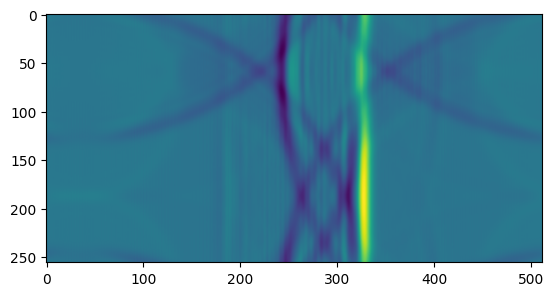

  0%|                                                                              | 1/1024 [00:00<01:47,  9.53it/s]

<Figure size 500x300 with 0 Axes>

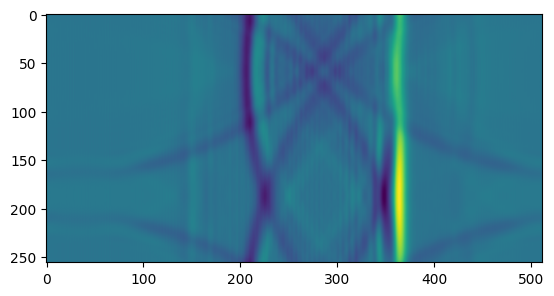

  6%|████▊                                                                       | 65/1024 [00:00<00:05, 186.02it/s]

<Figure size 500x300 with 0 Axes>

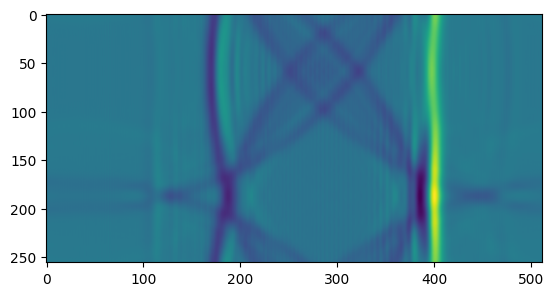

 13%|█████████▍                                                                 | 129/1024 [00:00<00:04, 211.57it/s]

<Figure size 500x300 with 0 Axes>

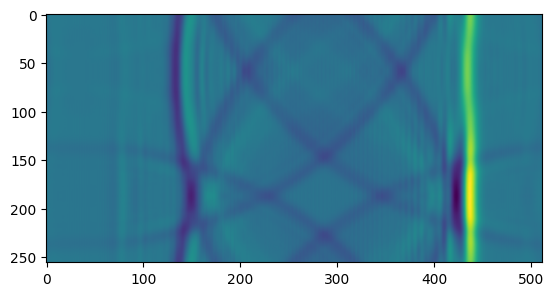

 19%|██████████████▏                                                            | 193/1024 [00:00<00:03, 222.08it/s]

<Figure size 500x300 with 0 Axes>

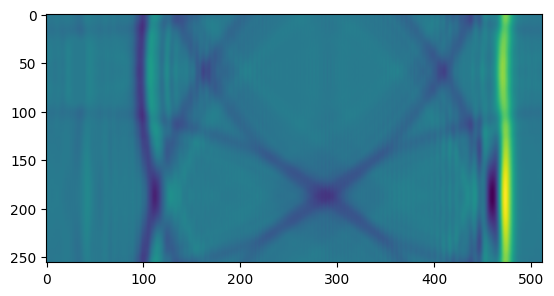

 25%|██████████████████▊                                                        | 257/1024 [00:01<00:03, 213.92it/s]

<Figure size 500x300 with 0 Axes>

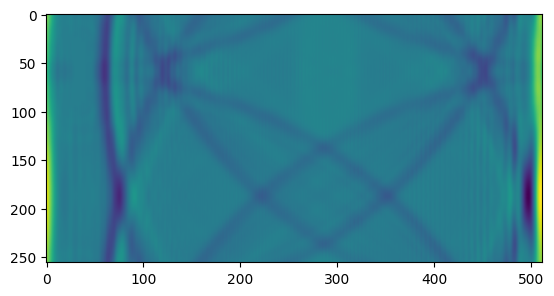

 31%|███████████████████████▌                                                   | 321/1024 [00:01<00:03, 218.44it/s]

<Figure size 500x300 with 0 Axes>

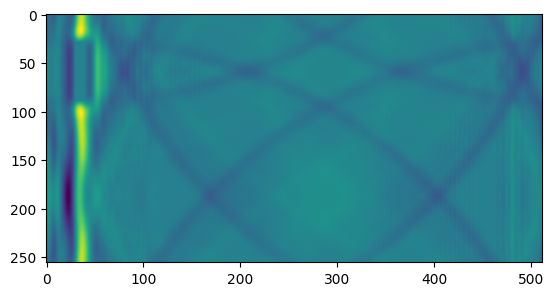

 38%|████████████████████████████▏                                              | 385/1024 [00:01<00:02, 223.04it/s]

In [ ]:
E_cpu_out = np.zeros(E_cpu.shape, dtype=E_cpu.dtype)
H_cpu_out = np.zeros(H_cpu.shape, dtype=H_cpu.dtype)

total_loops = 1024

kernel_events = []
with NanoTimer() as timer:
    with cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE) as queue:
        for i in tqdm(range(total_loops)):
            ev_update_E = gpu_program.update_E(
                queue, 
                global_size, workgroup_size,
                E_gpu.data, H_gpu.data,
                a_0_gpu.data, a_1_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            kernel_events.append(('update_E', ev_update_E))
            cl.enqueue_barrier(queue)
            ev_update_H = gpu_program.update_H(
                queue, 
                global_size, workgroup_size,
                E_gpu.data, H_gpu.data,
                b_0_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            kernel_events.append(('update_H', ev_update_H))
            queue.flush()

            if i % 64 == 0:
                E_gpu.get(queue=queue, ary=E_cpu_out)
                H_gpu.get(queue=queue, ary=H_cpu_out)
                fig = plt.figure(figsize=(5,3))
                #data = np.linalg.norm(E_cpu_out, ord=2, axis=3)
                data = E_cpu_out[:,:,:,0]
                data = np.sum(data, axis=0)
                plt.figure()
                plt.imshow(data)
                plt.show()
gpu_submit_ns = timer.get_delta_ns()
print(f"gpu_queue_command={gpu_submit_ns*1e-6:.3f} ms")

gpu_pass_ns = gpu_submit_ns / total_loops
gpu_cell_rate = total_cells / (gpu_pass_ns*1e-9)

print(f"gpu_submit_time={gpu_submit_ns*1e-6:.3f} ms")
print(f"gpu_pass_time={gpu_pass_ns*1e-6:.3f} ms")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")

In [ ]:
def get_profiling_info(ev):
    keys = [
        "COMPLETE",
        "END",
        "QUEUED",
        "START",
        "SUBMIT",
    ]
    return { key.lower(): ev.get_profiling_info(getattr(cl.profiling_info, key)) for key in keys }
    
ns_per_tick = device_info["profiling_timer_resolution"]

profile_info = [get_profiling_info(ev) for ev in kernel_events]
event_types = list(profile_info[0].items())
event_types = sorted(event_types, key=lambda x: x[1])
event_types = [k for k,v in event_types]
print(event_types)

total_events = len(event_types)
N = len(profile_info)
Y = np.zeros((total_events, N), dtype=np.float64)
X = np.arange(len(profile_info))

for j, key in enumerate(event_types):
    y = Y[j]
    for i, info in enumerate(profile_info):
        time_ticks = info[key]
        time_ns = ns_per_tick*time_ticks
        y[i] = time_ns

Y -= np.min(Y)

plt.figure()
# i = slice(64, 64+10)
i = slice(0, N)
for j, key in enumerate(event_types):
    # if j <= 1: continue
    plt.plot(X[i], Y[j,i] * 1e-6, label=key, marker=".")
plt.grid(True)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Time (ms)")
plt.title("Timeline")
plt.show()

exec_ns = Y[3] - Y[2]
plt.figure()
plt.plot(exec_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Execution time")
plt.show()

print(f"exec_median={np.median(exec_ns)*1e-3:.3f}us")

delay_dispatch_ns = Y[2,1:] - Y[3,:-1] 
plt.figure()
plt.plot(delay_dispatch_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Dispatch delay")
plt.show()

# print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")
print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")